# SURF, SIFT Descriptors


In [1]:
import cv2 as cv
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_folder1 = os.path.join(os.curdir,'dataset1(kvadr)')
data_set1 = [os.path.join(data_folder1,file) for file in os.listdir(data_folder1) if os.path.isfile(os.path.join(data_folder1,file))]
data_folder2 = os.path.join(os.curdir,'dataset2(pony)')
data_set2 = [os.path.join(data_folder2,file) for file in os.listdir(data_folder2) if os.path.isfile(os.path.join(data_folder2,file))]


In [4]:
kvadrs = [cv.imread(image,0) for image in data_set1]

In [3]:
ponies = [cv.imread(image,0) for image in data_set2]

In [12]:
data_set1

['./dataset1(kvadr)/IMG_3091.JPG',
 './dataset1(kvadr)/IMG_3380(1).jpg',
 './dataset1(kvadr)/IMG_3050.jpg',
 './dataset1(kvadr)/IMG_3350.JPG',
 './dataset1(kvadr)/IMG_3097.jpg',
 './dataset1(kvadr)/IMG_3053.jpg',
 './dataset1(kvadr)/IMG_3391(1).JPG',
 './dataset1(kvadr)/IMG_3062.jpg',
 './dataset1(kvadr)/IMG_3533.JPG',
 './dataset1(kvadr)/IMG_3059.jpg',
 './dataset1(kvadr)/IMG_3391.JPG',
 './dataset1(kvadr)/IMG_3056.jpg',
 './dataset1(kvadr)/IMG_3109.JPG',
 './dataset1(kvadr)/IMG_3187.jpg',
 './dataset1(kvadr)/IMG_3060.jpg',
 './dataset1(kvadr)/IMG_3124.jpg',
 './dataset1(kvadr)/IMG_3130.JPG',
 './dataset1(kvadr)/IMG_3065.jpg',
 './dataset1(kvadr)/IMG_3358.JPG',
 './dataset1(kvadr)/IMG_3499.JPG',
 './dataset1(kvadr)/IMG_3178.JPG',
 './dataset1(kvadr)/IMG_3353.JPG',
 './dataset1(kvadr)/IMG_3365.jpg',
 './dataset1(kvadr)/IMG_3075.JPG',
 './dataset1(kvadr)/IMG_3366.JPG',
 './dataset1(kvadr)/IMG_3063.jpg',
 './dataset1(kvadr)/IMG_3415.JPG',
 './dataset1(kvadr)/IMG_3070.jpg',
 './dataset1(k

In [15]:
surf = cv.xfeatures2d.SURF_create(700)
sift = cv.xfeatures2d.SIFT_create()

In [5]:
kp1, des1 = surf.detectAndCompute(kvadrs[7],None)
kp2, des2 = surf.detectAndCompute(kvadrs[2],None)

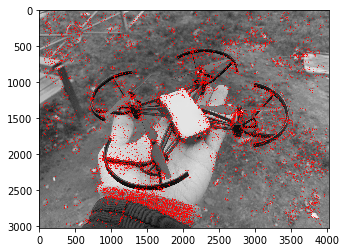

(<matplotlib.image.AxesImage at 0x7fb4022bf110>, None)

In [26]:
img1 = cv.drawKeypoints(kvadrs[7],kp1,None,(255,0,0),4)

plt.imshow(img1),plt.show()


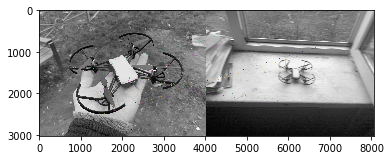

(<matplotlib.image.AxesImage at 0x7fb402277c10>, None)

In [16]:
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv.drawMatches(kvadrs[7],kp1,kvadrs[2],kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()


In [8]:
MIN_MATCH_COUNT = 5

In [4]:
def compare(descriptor, img1, img2, min_match_count, verbose=False):
    kpts1,des1 = descriptor(img1,None)
    kpts2,des2 = descriptor(img2,None)
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks = 50)
    #bf = cv.BFMatcher()
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = [m for m,n in matches if m.distance < 0.7*n.distance]
    if len(good)>min_match_count:
        src_pts = np.float32([ kpts1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kpts2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        #img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
        msed = np.mean([np.sqrt(np.sum(diff)) for diff in (np.power(pts-dst,2))]/(np.sqrt(h**2+w**2)))
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    return kpts1, kpts2, good, matchesMask, msed

In [40]:
key_pts1, key_pts2, good, matchesMask,msed = compare(descriptor=surf.detectAndCompute,img1=kvadrs[9],img2=kvadrs[13],
                                                     min_match_count=10)

In [5]:
import itertools
import time

In [6]:
alg_dict=dict(sift=cv.xfeatures2d.SIFT_create().detectAndCompute,
              surf=cv.xfeatures2d.SURF_create(700).detectAndCompute)
inliers_matches = dict()
indexes = list(itertools.product(alg_dict.keys(),["inliers/matches","distance MSE","time (s)"]))
for im_j_idx in range(len(ponies)):
    inliers_matches["img"+str(im_j_idx)]=list()

In [9]:
for alg_name, alg in alg_dict.items():
    for im_i_idx, image_i in enumerate(ponies):
        time_start=time.monotonic()
        _, __, match, inlier ,msd = compare(descriptor=alg,img1=image_i,img2=ponies[6],
                                                     min_match_count=MIN_MATCH_COUNT)
        time_end=time.monotonic()
        if match==0:
            match=np.inf
        inliers_matches["img"+str(im_i_idx)].append(np.sum(inlier)/(len(match)))
        inliers_matches["img"+str(im_i_idx)].append(msd)
        inliers_matches["img"+str(im_i_idx)].append(time_end-time_start)

Not enough matches are found - 0/5


UnboundLocalError: local variable 'msed' referenced before assignment